<a href="https://colab.research.google.com/github/tkhan3/machinelearning/blob/master/Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective of this study is to build a proactive system that will help in predicting potential employees that are on the risk of attritition. This system will help HR and Organization is identifying the potential candidates that are likely to leave organization by raising a flag. HR and Organziation can examine these cases and can determine if they need to intervene and take some steps to prevent this. This will also help HR in building contigency which includes finidng replacement or looking for new hire or plan for transition. **

**This has two parts. First part includes exploratory study which will help in understanding the underlying data points/variable/factors. This exploratory study help in discovering various distributions and finiding the issues with the data. This will also assist in determining what all algorithms can be applicable and if some variable transformations are needed.**

**Second part of the study is training various machine learning models for classification. These machine learning model will predict if an employee is on the risk of attrition or not. In this study we are generating probabilities of the attrition but this can be done easily by extending this work. Multiple machine learning models are trained and their performance is compared with the help of Confusion Matrix.**

**There is a class imbalance in the dataset. So in this study precision and recall are more important parameter to measure the efficacy of the qualifier. We can't just look at the Accuracy as there is a class imbalance in the dataset.**

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#import pandas as pd
!google-drive-ocamlfuse drive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip3 install seaborn==0.9.0
import pydot
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install sklearn_pandas

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110856 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

**Below code import required machine learning and visualization libraries.**

In [2]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


**Setting up path for google drive where the data is loaded. Then we read the data from there into a csv file.**

In [0]:
import os
drive_path = 'drive/DL_COLAB/'

HR_ANALYTICS_PATH = os.path.join(drive_path,"hr_analytics")

def load_hr_data(filename, file_path=HR_ANALYTICS_PATH):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path,sep="|")

In [0]:
hr_data_full = load_hr_data("Updated_HR_15000.csv")

**Overall dataset has 15000 records and 10 columns**

In [5]:
hr_data_full.shape

(14999, 10)

**Below are the list of columns in the dataset**

In [6]:
hr_data_full.columns

Index(['attrition', 'salary_level', 'department', 'number_years_in_company',
       'last_appraisal_score', 'number_of_project',
       'average_billable_monthly_hours', 'behavioural_issue',
       'recent_promotion', 'employee_engagement_level'],
      dtype='object')

**Below are the histograms for the different numeric vairables. This will helps in understanding distribution of the different variables.**

**For behavioural issues it seems 10% of the examples have behavioural problems. We can see most of the employees has spent 150-300 as average monthly hours. Similarly most of the observations were evaluated either average or high in their last performance review. We can also see most of the people have worked between 3-5 projects. There are very small number of employees were present in the dataset which were promoted in last 1 year. Similarly most of the employees have spent 3-5 years with small number of employees have spent over 10 years.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3195c83c18>,
      dtype=object)

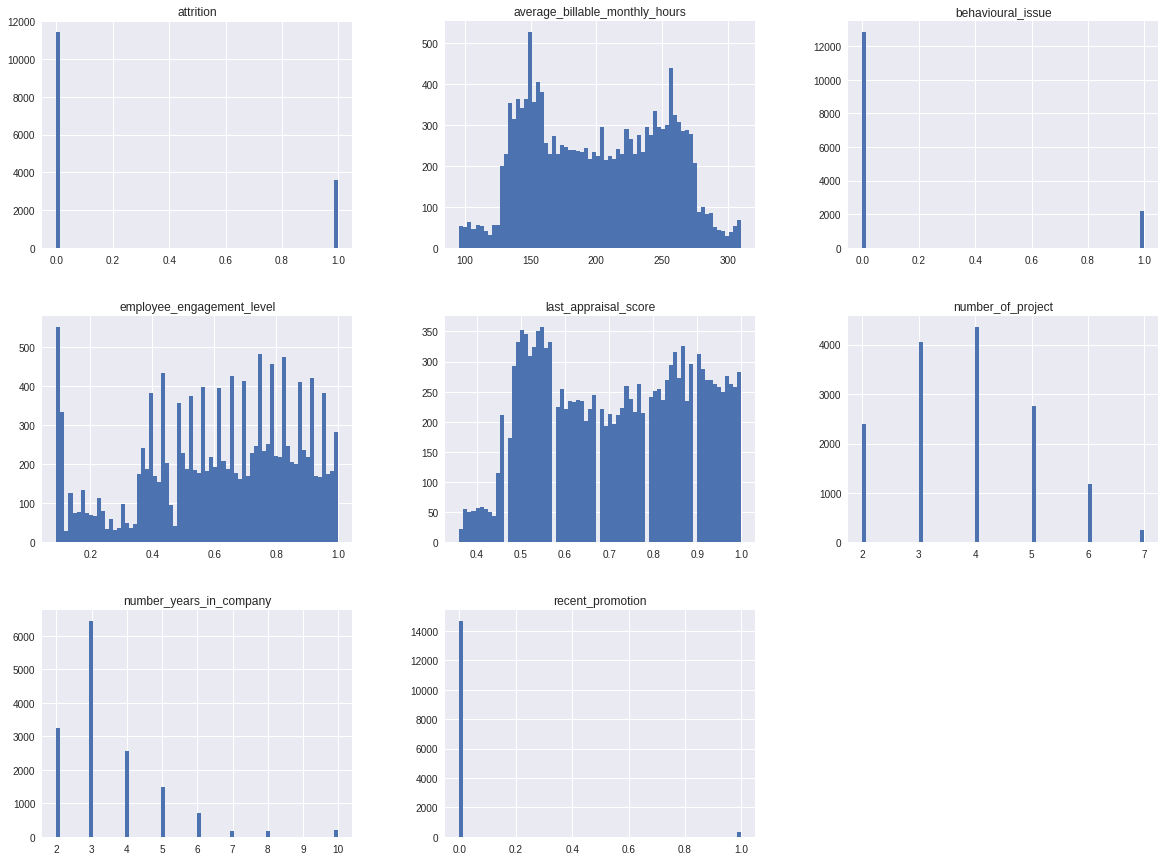

In [7]:
hr_data_full.hist(bins=70, figsize=(20,15))

**Instead of providing actual salary details it was measured as low medium and high. This scale is done internally with-in a Department of the company and with in Job Designation. So low salary means low in among the peers working on same band and in same department.**

In [8]:
print (hr_data_full.salary_level.unique())
print (hr_data_full.department.unique())

['low' 'medium' 'high']
['Technology' 'HR' 'management' 'Support' 'Sales_Marketing']


**Below is the distribution of the output class in full dataset. Green bar shows ratio of the examples for which historical attrition was yes and Blue bar shows examples for which attrition was 'NO. We have around 20% observations of positive class i.e. (attrition=Yes)'.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  cat_pos = np.ones(swarm_data.size) * center


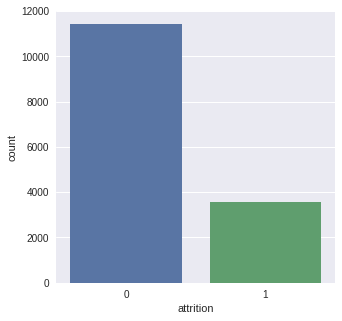

In [9]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x="attrition",data=hr_data_full)

In [10]:
hr_data_full[hr_data_full.attrition == 1]['attrition'].count()/hr_data_full['attrition'].count()

0.2380825388359224

**Below is the graph that shows level of attrition for different satisfaction level. We can see most of the attrition is in employee with low and medium satisfaction level. However there is a very small attrition among the employees having higher satisfaction level. Satisfaction scores are provided based upon an internal survey executed by the organization**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


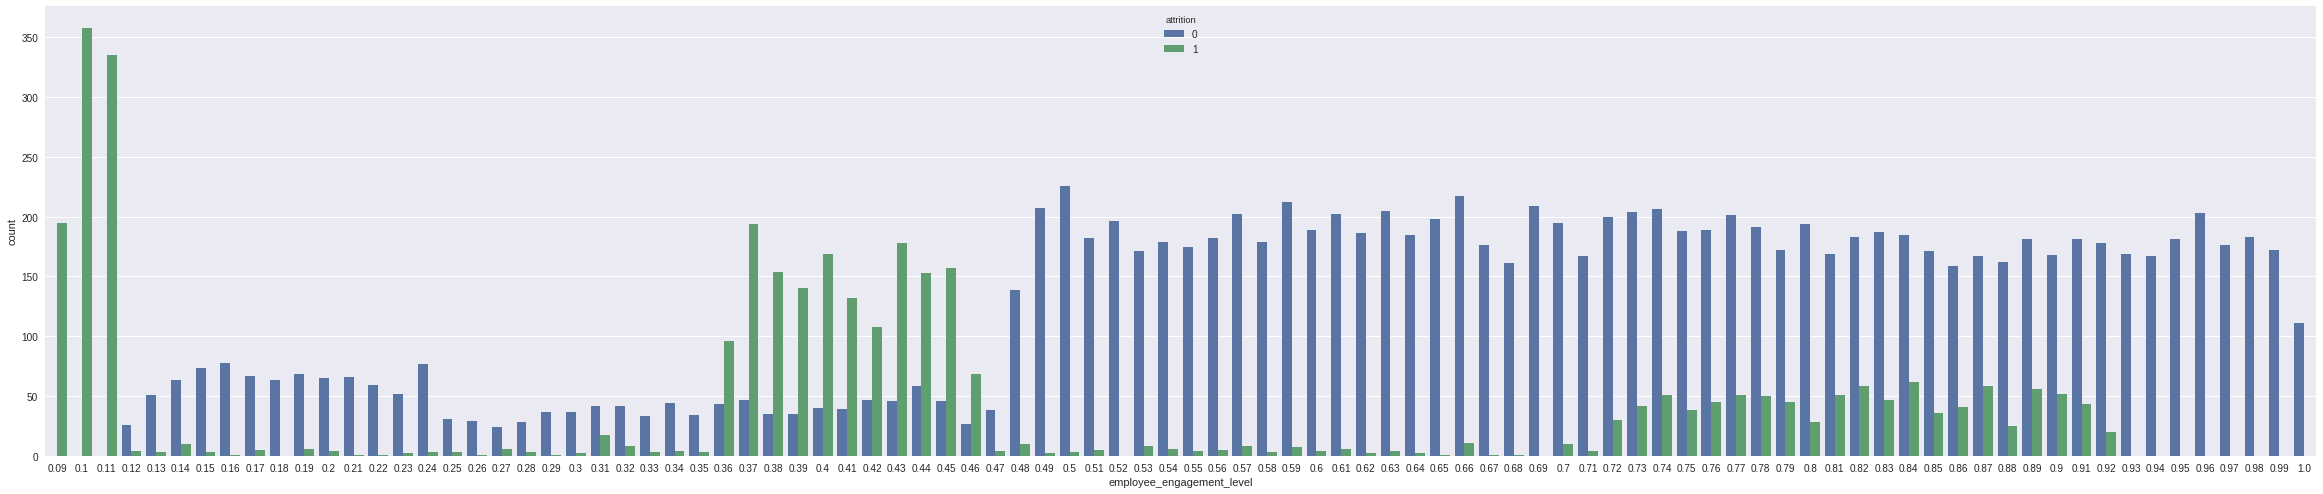

In [11]:
sns.set(rc={'figure.figsize':(40.7,8.27)})
sns.countplot(x="employee_engagement_level",data=hr_data_full,hue='attrition')

**Below is the graph that shows level of attrition for different salary level. We can see most of the attrition is in employee with low and medium salary level. However there is a very small attrition among the employees having higher higher salaries.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


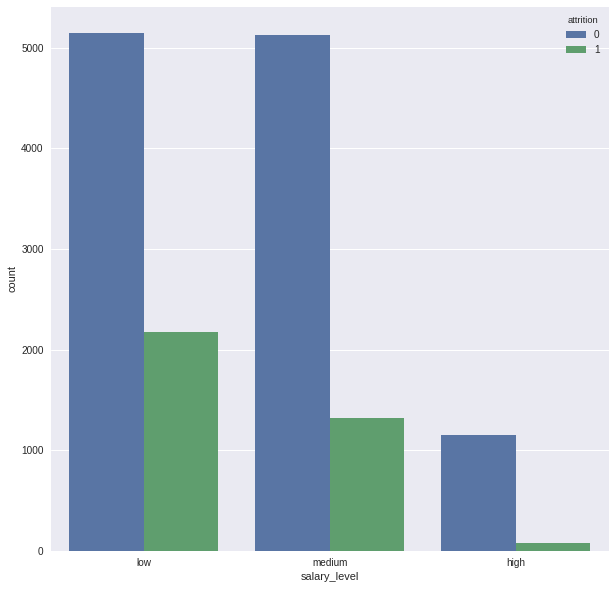

In [12]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x="salary_level",data=hr_data_full,hue='attrition')

**Below graph shows the distribution of attrition on average number of project/task worked by an employee in a year. We can see attrition is high among the people who worked on below average number of projects and employees who have worked on very high number of projects/tasks. This shows there may be an issue with the worklife balance among the employees who have worked on too many projects which might lead to attrition. Similarly employee who had worked on small number of projects have shown higher attrition rate so they may not be satisfied with the work they are doing or they got disengaged because enough work is not available.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


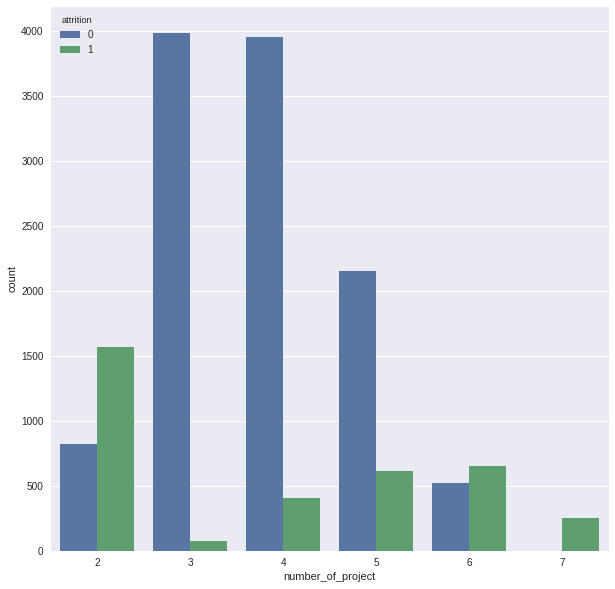

In [13]:
sns.countplot(x="number_of_project",data=hr_data_full,hue='attrition')

**Below is the graph for distribution of attrition on last evaluation. We can see high attrition among the people who ever evaluated high. Organization should determine reason for it.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


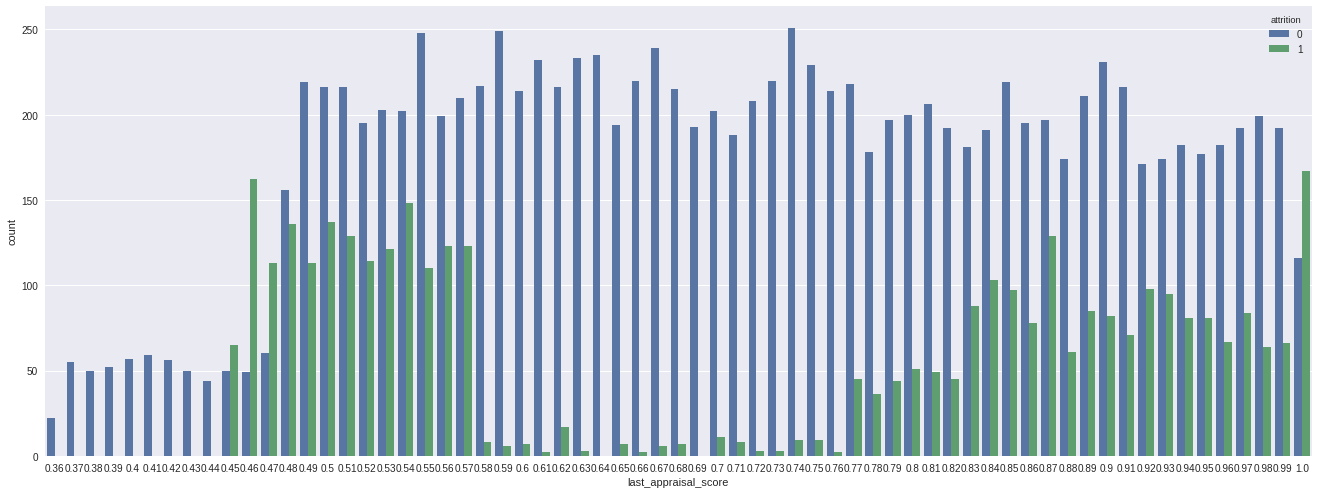

In [14]:
sns.set(rc={'figure.figsize':(22.7,8.27)})
sns.countplot(x="last_appraisal_score",data=hr_data_full,hue='attrition')

**Below is the distribution of attrition based upon time spend in company. We can see higher attrition among the people who had 3-5 years of experience. Attrition trend is lower among the people who has < 2 years of expereince and people who had 7+ years of experience.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


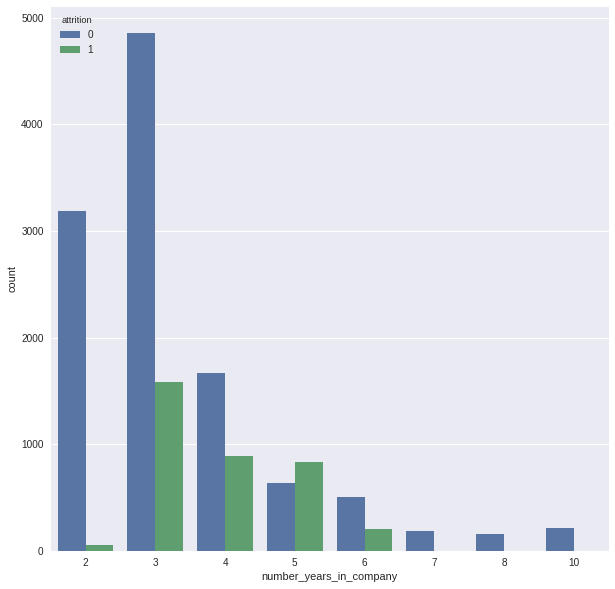

In [15]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x="number_years_in_company",data=hr_data_full,hue='attrition')

***Below is the distribution of attrition based upon the fact that if person had a recent promotion. There is a higher attrition rate among the people who were not promoted.***

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


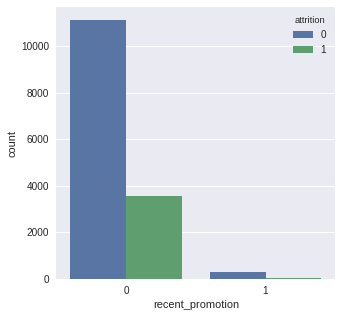

In [16]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x="recent_promotion",data=hr_data_full,hue='attrition')

**Below is the distribution of attrition based for each Department. We can see higer attrition in IT.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


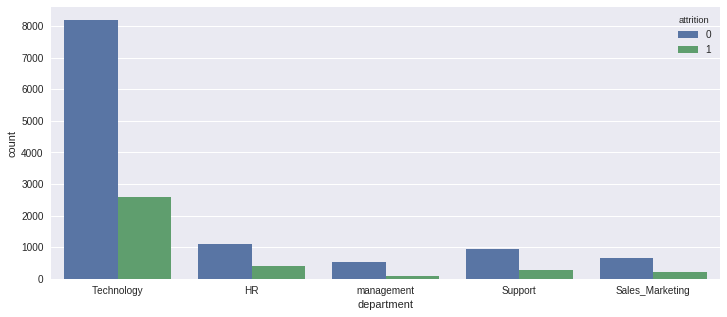

In [17]:
sns.set(rc={'figure.figsize':(12,5)})
sns.countplot(x="department",data=hr_data_full,hue='attrition')

***Below we are creating Training and Test Split. Entire data is divided into 90% Training Set and 10% Test Set. The entire dataset is first shuffled and then split. To address the class imbalance problem and to have good test set we are using Stratified sampling on number of attrition cases in each Training and Test Set. Stratified sampling will keep proportion of example with attrition 'Yes' and "No" same in training and test set.***

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(hr_data_full, hr_data_full["attrition"]):
    hr_data_train = hr_data_full.loc[train_index]
    hr_data_test = hr_data_full.loc[test_index]

**Below cell shows Number of Records in Training Set and Number of Record in Test Set.**

In [19]:
print (hr_data_train.shape)
print (hr_data_test.shape)

(13499, 10)
(1500, 10)


In [20]:
print (type(hr_data_train))
print (type(hr_data_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


**Creating Labels (Attrition = Yes or No) which is our target class. These labels will be used to train machine learning algorithms and during the test time these tables will be used to measure performance of the trained machine learning algorithm.**

In [0]:
hr_data_train_label = hr_data_train["attrition"].copy()
hr_data_test_label =  hr_data_test["attrition"].copy()

In [22]:
print (hr_data_train_label.shape)
print (hr_data_test_label.shape)

(13499,)
(1500,)


**As machine learning algorithm should not get the labels of training and test set we need to remove it.**

In [0]:
hr_data_train = hr_data_train.drop("attrition",axis=1)
hr_data_test = hr_data_test.drop("attrition",axis=1)

**Summary of Training Set about the various fields**

In [24]:
hr_data_train.describe()

,number_years_in_company,last_appraisal_score,number_of_project,average_billable_monthly_hours,behavioural_issue,recent_promotion,employee_engagement_level
count,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.00000
mean,3.503445,0.716707,3.806430,201.149567,0.144529,0.020890,0.61276
std,1.461173,0.171250,1.234811,49.969348,0.351639,0.143023,0.24897
min,2.000000,0.360000,2.000000,96.000000,0.000000,0.000000,0.09000
25%,3.000000,0.560000,3.000000,156.000000,0.000000,0.000000,0.44000
50%,3.000000,0.720000,4.000000,200.000000,0.000000,0.000000,0.64000
75%,4.000000,0.870000,5.000000,245.000000,0.000000,0.000000,0.82000
max,10.000000,1.000000,7.000000,310.000000,1.000000,1.000000,1.00000


In [25]:
hr_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
attrition                         14999 non-null int64
salary_level                      14999 non-null object
department                        14999 non-null object
number_years_in_company           14999 non-null int64
last_appraisal_score              14999 non-null float64
number_of_project                 14999 non-null int64
average_billable_monthly_hours    14999 non-null int64
behavioural_issue                 14999 non-null int64
recent_promotion                  14999 non-null int64
employee_engagement_level         14999 non-null float64
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


**There are two categorical variables in our dataset Department and Salary. However there are 7 numeric variables in our dataset. These variables has to be treated differently to prepare the data that can be fed into machine learning algorith**

In [0]:
cat_attribute = ['department','salary_level']
numeric_attribute = ["number_years_in_company","last_appraisal_score","number_of_project","average_billable_monthly_hours","behavioural_issue","recent_promotion","employee_engagement_level"]

In [27]:
print (len(cat_attribute))
print (len(numeric_attribute))

2
7


In [0]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
        return self
    def transform(self, X, y=None):
        #return X.fillna(self.most_frequent_)
        return X


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Below is the pipeline for numeric variable. It undergoes three stages. We first select the numeric variables and then impute the missing values and standardize the values. Standardization of values are required as different variables are measured on different scale. For eg. satisfaction and evaluation was measured between 0-1 to and hours worked are measured from 0-350 hours.**

In [0]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numeric_attribute)),
        ("imputer", SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
import sklearn_pandas as skpanda

**Below is the pipeline for categorical variable. It undergoes three stages. We first select the categorical variables and then impute the missing values. Then we convert the different levels of categorical variables into one Hot encoding..**

In [0]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_attribute)),
        ("imputer", skpanda.CategoricalImputer()),
        ("cat_encoder",OneHotEncoder(sparse=False,handle_unknown='ignore' )),
        ])

**Below we do the union of the transformed numeric and categorical variables we create one record for each observation**

In [0]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

**Pipeline is executed on both type of variables. We have to apply pipeline on both training set and test set as they need to undergo similar transformation.**

In [0]:
x_train  = preprocess_pipeline.fit_transform(hr_data_train)
x_test =  preprocess_pipeline.transform(hr_data_test)

**creating labels for train and test set.**

In [0]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(hr_data_train_label)
y_test = le.fit_transform(hr_data_test_label)

**Size of final training and test set. Due to One hot encoding number of columns are increased from 10 to 20. One column for each level of categorical variables.**

In [37]:
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (hr_data_train.shape)

(13499, 15)
(1500, 15)
(13499,)
(1500,)
(13499, 9)


**Below is the computation of correlation between different numeric variables. We can see positive correlation between last evaluation and average monthly hours pair. However there is negative correlation between number of project and satisfaction level which may indicate lesser worklife balance.**

In [0]:
correlation_matrix = hr_data_train.corr()

In [39]:
print (correlation_matrix)

                                number_years_in_company  last_appraisal_score  \
number_years_in_company                        1.000000              0.134387   
last_appraisal_score                           0.134387              1.000000   
number_of_project                              0.196456              0.346520   
average_billable_monthly_hours                 0.127994              0.338556   
behavioural_issue                              0.005303             -0.008767   
recent_promotion                               0.064176             -0.005600   
employee_engagement_level                     -0.099282              0.105310   

                                number_of_project  \
number_years_in_company                  0.196456   
last_appraisal_score                     0.346520   
number_of_project                        1.000000   
average_billable_monthly_hours           0.417131   
behavioural_issue                       -0.003130   
recent_promotion                 

In [0]:
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

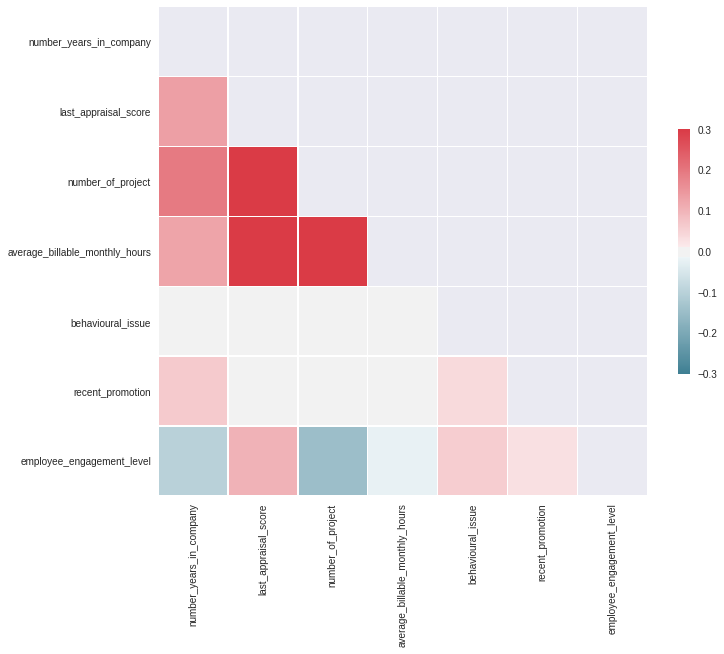

In [41]:
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Training a logisitic regression based classifier.**

In [0]:
logistic_clf = LogisticRegression(random_state=42,class_weight ='balanced',solver='lbfgs',max_iter=1000)

In [43]:
logistic_clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [44]:
logistic_regression_scores = cross_val_score(logistic_clf, x_train, y_train, cv=10)
y_train_pred_logistic = cross_val_predict(logistic_clf, x_train, y_train, cv=10)
print (logistic_regression_scores.mean())

0.7576112935529121


In [52]:
cm  = confusion_matrix(y_train, y_train_pred_logistic)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

7649
2636
636
2578


Confusion matrix, without normalization
[[7649 2636]
 [ 636 2578]]


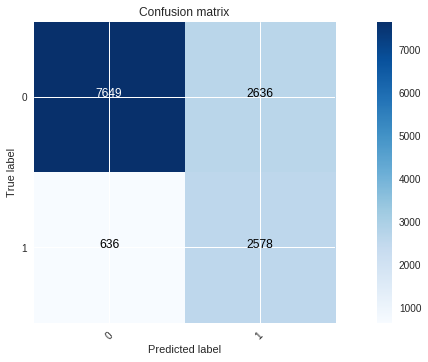

In [53]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_logistic = logistic_clf.predict(x_test)

In [55]:
cm = confusion_matrix(y_test,y_test_pred_logistic)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

883
260
68
289


Confusion matrix, without normalization
[[883 260]
 [ 68 289]]


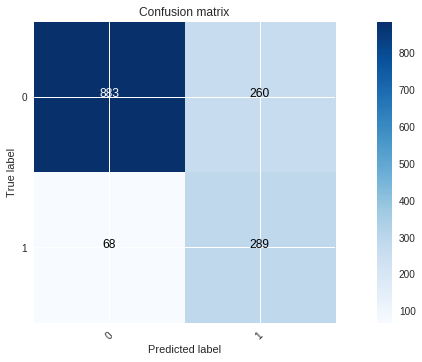

In [56]:
plot_confusion_matrix(cm,[0,1])

In [57]:
print (classification_report(y_test,y_test_pred_logistic))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1143
           1       0.53      0.81      0.64       357

   micro avg       0.78      0.78      0.78      1500
   macro avg       0.73      0.79      0.74      1500
weighted avg       0.83      0.78      0.79      1500



**Training K Nearest Neighbor**

In [58]:
param_grid = [{"weights":["uniform","distance"],"n_neighbors":[2,3,4,5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, verbose=3, n_jobs=-1)
grid_search.fit(x_train, y_train)
print (grid_search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   34.2s


{'n_neighbors': 4, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.8min finished


In [59]:
knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=2)
knn_clf.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')

In [60]:
knn_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_knn = cross_val_predict(knn_clf, x_train, y_train, cv=10)
print (knn_scores.mean())

0.9717025374987251


In [61]:
cm  = confusion_matrix(y_train,y_train_pred_knn)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

10019
266
116
3098


Confusion matrix, without normalization
[[10019   266]
 [  116  3098]]


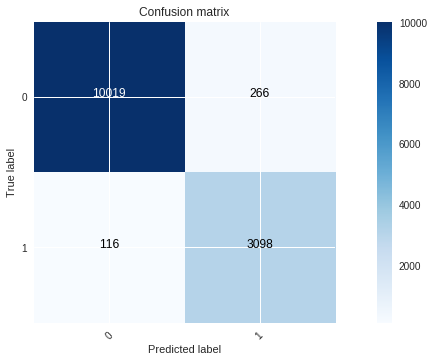

In [62]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_knn = knn_clf.predict(x_test)

In [64]:
cm = confusion_matrix(y_test,y_test_pred_knn)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1117
26
12
345


Confusion matrix, without normalization
[[1117   26]
 [  12  345]]


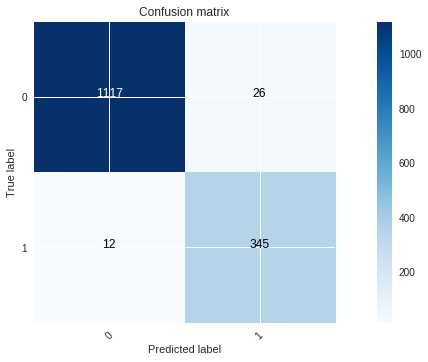

In [65]:
plot_confusion_matrix(cm,[0,1])

In [66]:
print (classification_report(y_test,y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1143
           1       0.93      0.97      0.95       357

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.96      0.97      0.97      1500
weighted avg       0.98      0.97      0.97      1500



**Train a SVM Model**

In [67]:
svm_clf = SVC(gamma="auto",random_state=42)
svm_clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
svm_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_svm = cross_val_predict(svm_clf, x_train, y_train, cv=10)
print (svm_scores.mean())

0.9717025374987251


In [0]:
y_test_pred_svm = svm_clf.predict(x_test)

In [0]:
cm  = confusion_matrix(y_train,y_train_pred_svm)

Confusion matrix, without normalization
[[10001   284]
 [  303  2911]]


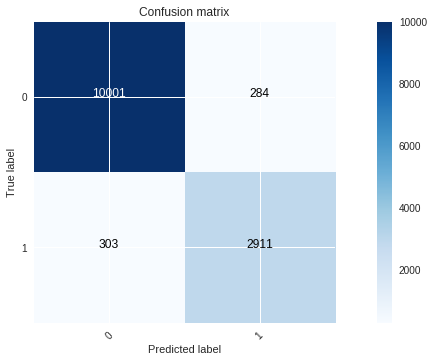

In [71]:
plot_confusion_matrix(cm,[0,1])

In [72]:
cm  = confusion_matrix(y_test,y_test_pred_svm)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1121
22
34
323


Confusion matrix, without normalization
[[1121   22]
 [  34  323]]


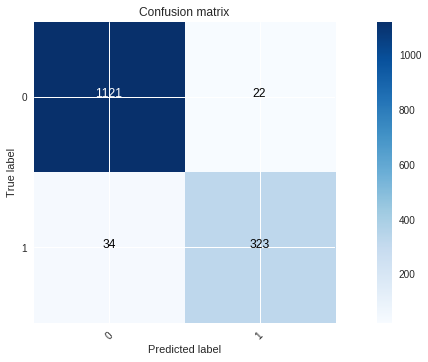

In [73]:
plot_confusion_matrix(cm,[0,1])

In [74]:
print (classification_report(y_test,y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1143
           1       0.94      0.90      0.92       357

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.95      0.94      0.95      1500
weighted avg       0.96      0.96      0.96      1500



**Training Gradient Boosting Algorithm**

In [75]:
xgboost_clf = XGBClassifier(random_state=42)
xgboost_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [76]:
xgboost_scores = cross_val_score(xgboost_clf, x_train, y_train, cv=10)
y_train_pred_xgboost = cross_val_predict(xgboost_clf, x_train, y_train, cv=10)
xgboost_scores.mean()

0.974815022019115

In [0]:
cm  = confusion_matrix(y_train,y_train_pred_xgboost)

Confusion matrix, without normalization
[[10181   104]
 [  236  2978]]


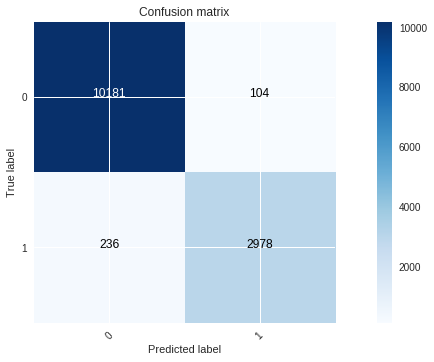

In [78]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_xgboost = xgboost_clf.predict(x_test)

In [80]:
cm  = confusion_matrix(y_test,y_test_pred_xgboost)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1135
8
25
332


Confusion matrix, without normalization
[[1135    8]
 [  25  332]]


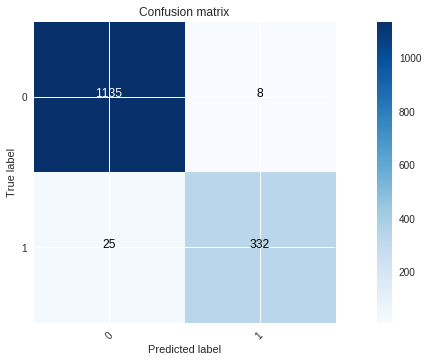

In [81]:
plot_confusion_matrix(cm,[0,1])

In [82]:
print (classification_report(y_test,y_test_pred_xgboost))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1143
           1       0.98      0.93      0.95       357

   micro avg       0.98      0.98      0.98      1500
   macro avg       0.98      0.96      0.97      1500
weighted avg       0.98      0.98      0.98      1500



**Training Neural Network**

In [0]:
# create model
neural_net = Sequential()
neural_net.add(Dense(8, input_dim=15, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))
# Compile model
neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
neural_net.fit(x_train, y_train, validation_split=0.1,epochs=1500, batch_size=10)

Train on 12149 samples, validate on 1350 samples
Epoch 1/1500
12149/12149 [==============================] - 2s 170us/step - loss: 0.3024 - acc: 0.8748 - val_loss: 0.1652 - val_acc: 0.9407
Epoch 2/1500
12149/12149 [==============================] - 2s 124us/step - loss: 0.1519 - acc: 0.9562 - val_loss: 0.1447 - val_acc: 0.9563
Epoch 3/1500
12149/12149 [==============================] - 2s 124us/step - loss: 0.1382 - acc: 0.9612 - val_loss: 0.1359 - val_acc: 0.9637
Epoch 4/1500
12149/12149 [==============================] - 1s 123us/step - loss: 0.1316 - acc: 0.9637 - val_loss: 0.1313 - val_acc: 0.9607
Epoch 5/1500
12149/12149 [==============================] - 2s 124us/step - loss: 0.1275 - acc: 0.9648 - val_loss: 0.1293 - val_acc: 0.9652
Epoch 6/1500
12149/12149 [==============================] - 2s 124us/step - loss: 0.1229 - acc: 0.9660 - val_loss: 0.1263 - val_acc: 0.9659
Epoch 7/1500
12149/12149 [==============================] - 2s 125us/step - loss: 0.1201 - acc: 0.9666 - val_lo

In [0]:
y_train_pred_neural_net = neural_net.predict_classes(x_train)

In [0]:
cm = confusion_matrix(y_train,y_train_pred_neural_net)

Confusion matrix, without normalization
[[9541  744]
 [2825  389]]


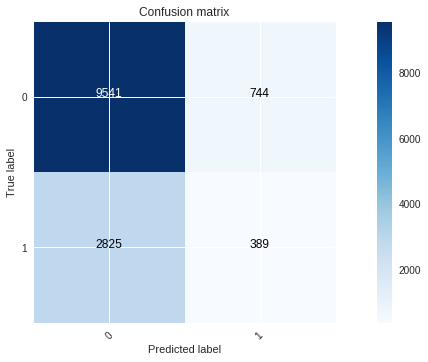

In [86]:
plot_confusion_matrix(cm,[0,1])

In [88]:
print (classification_report(y_train,y_train_pred_neural_net))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84     10285
           1       0.34      0.12      0.18      3214

   micro avg       0.74      0.74      0.74     13499
   macro avg       0.56      0.52      0.51     13499
weighted avg       0.67      0.74      0.68     13499



In [0]:
y_test_pred_neural_net = neural_net.predict_classes(x_test)

In [0]:
cm = confusion_matrix(y_test,y_test_pred_neural_net)

Confusion matrix, without normalization
[[1128   15]
 [  19  338]]


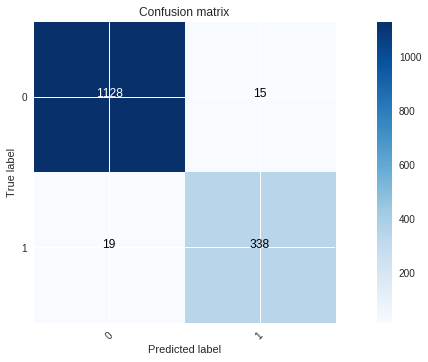

In [91]:
plot_confusion_matrix(cm,[0,1])

In [92]:
print (classification_report(y_test,y_test_pred_neural_net))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1143
           1       0.96      0.95      0.95       357

   micro avg       0.98      0.98      0.98      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.98      0.98      0.98      1500

